**General Description**

The following notebook contains the code to create, train, validate, and test a rainfall-runoff model using an LSTM network architecture. The code allows for the creation of single-basin models but is conceptualized to create regional models. 

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050) [1]. For a more flexible, robust, and modular implementation of deep learning methods in hydrological modeling, we advise the use of Neural Hydrology. 

**Experiment Details**
- In this example we use the LSTM architecture, to create a regional rainfall-runoff model for 669 basins of the CAMELS_GB [2] dataset.
- The setup of the experiment is based on [3].

**Authors:**
- Eduardo Acuña Espinoza (eduardo.espinoza@kit.edu)

**References:**

[1]: Kratzert, F., Gauch, M., Nearing, G., & Klotz, D. (2022). NeuralHydrology – A Python library for deep learning research in hydrology. Journal of Open Source Software, 7, 4050. https://doi.org/10.21105/joss.04050

[2]: Coxon, G., Addor, N., Bloomfield, J. P., Freer, J., Fry, M., Hannaford, J., Howden, N. J. K., Lane, R., Lewis, M., Robinson, E. L., Wagener, T., and Woods, R.: CAMELS-GB: Hydrometeorological time series and landscape attributes for 671 catchments in Great Britain, Earth Syst. Sci. Data Discuss., https://doi.org/10.5194/essd-2020-49, in review, 2020.

[3]: Lees, T., Buechel, M., Anderson, B., Slater, L., Reece, S., Coxon, G., & Dadson, S. J. (2021). Benchmarking data-driven rainfall–runoff models in Great Britain: A comparison of long short-term memory (LSTM)-based models with four lumped conceptual models. Hydrology and Earth System Sciences, 25(10), 5517–5534. https://doi.org/10.5194/hess-25-5517-2021


In [1]:
# Import necessary packages
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

sys.path.append("..")
# Import classes and functions from other files
from hy2dl.aux_functions.functions_evaluation import nse
from hy2dl.aux_functions.functions_training import nse_basin_averaged
from hy2dl.datasetzoo import get_dataset
from hy2dl.modelzoo import get_model
from hy2dl.utils.config import Config
from hy2dl.utils.optimizer import Optimizer
from hy2dl.utils.utils import set_random_seed, upload_to_device, write_report

# colorblind friendly palette
color_palette = {"observed": "#377eb8","simulated": "#4daf4a"}

Part 1. Initialize information

In [2]:
# Create a dictionary where all the information will be stored
experiment_settings = {}

# Experiment name
experiment_settings["experiment_name"] = "MFLSTM_hourly_us"

# paths to access the information
experiment_settings["path_data"] = "../data/CAMELS_US"
experiment_settings["path_entities"] = "../data/basin_id/basins_camels_us_hourly_516.txt"

# dynamic forcings and target
experiment_settings["dynamic_input"] = ["convective_fraction",
                                        "longwave_radiation",
                                        "potential_energy",
                                        "potential_evaporation",
                                        "pressure",
                                        "shortwave_radiation",
                                        "specific_humidity",
                                        "temperature",
                                        "total_precipitation",
                                        "wind_u",
                                        "wind_v"]

experiment_settings["target"] = ["QObs(mm/h)"]
experiment_settings["forcings"] = ["nldas_hourly"]

# static attributes that will be used. If one is not using static_inputs, initialize the variable as an empty list.
experiment_settings["static_input"] = ["elev_mean",
                                       "slope_mean",
                                       "area_gages2",
                                       "frac_forest",
                                       "lai_max",
                                       "lai_diff",
                                       "gvf_max",
                                       "gvf_diff",
                                       "soil_depth_pelletier",
                                       "soil_depth_statsgo",
                                       "soil_porosity",
                                       "soil_conductivity",
                                       "max_water_content",
                                       "sand_frac",
                                       "silt_frac",
                                       "clay_frac",
                                       "carbonate_rocks_frac",
                                       "geol_permeability",
                                       "p_mean",
                                       "pet_mean",
                                       "aridity",
                                       "frac_snow",
                                       "high_prec_freq",
                                       "high_prec_dur",
                                       "low_prec_freq",
                                       "low_prec_dur"]

# time periods
experiment_settings["training_period"] = ["1990-10-01 00:00:00", "2003-09-30 23:00:00"]
experiment_settings["validation_period"] = ["2003-10-01 00:00:00", "2008-09-30 23:00:00"]
experiment_settings["testing_period"] = ["2008-10-01 00:00:00", "2018-09-30 23:00:00"]

# model configuration
experiment_settings["hidden_size"]= 128
experiment_settings["batch_size_training"]= 256
experiment_settings["batch_size_evaluation"]= 1024
experiment_settings["epochs"]= 30
experiment_settings["dropout_rate"]= 0.4
experiment_settings["learning_rate"]= {1: 5e-4, 10: 1e-4, 25: 1e-5}
experiment_settings["validate_every"]= 4
experiment_settings["validate_n_random_basins"]= -1

experiment_settings["seq_length"]= 365*24
experiment_settings["custom_seq_processing"] = {"1D": {"n_steps": 351,"freq_factor": 24,},
                                                "1h": {"n_steps": (365 - 351) * 24, "freq_factor": 1}}

experiment_settings["custom_seq_processing_flag"] = True

experiment_settings["predict_last_n"] = 24
experiment_settings["unique_prediction_blocks"] = True
experiment_settings["dynamic_embedding"] = None

# device to train the model
experiment_settings["device"] = "gpu"  # cpu or cuda:0
experiment_settings["num_workers"] = 4 

# define random seed
experiment_settings["random_seed"] = 110

# dataset
experiment_settings["dataset"] = "hourly_camels_us"
# model
experiment_settings["model"] = "CudaLSTM"
experiment_settings["initial_forget_bias"] = 3.0

In [ ]:
# Initialize experiment configuration
config = Config(experiment_settings)
config.dump() # save the configuration to a YAML file for reproducibility

# Get dataset class
Dataset = get_dataset(config)

Folder '../results/MFLSTM_hourly_us_seed_110' was created to store the results.


Part 2. Create datasets and dataloaders used to train/validate the model

In [4]:
# Dataset training
training_dataset = Dataset(cfg= config, time_period= "training")

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(save_scaler=True)
training_dataset.standardize_data()

/home/eacuna/Hy2DL/hy2dl/datasetzoo/hourlycamelsus.py:133: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(streamflow_path, index_col=["date"], parse_dates=["date"])


In [5]:
# Dataloader training
train_loader = DataLoader(dataset=training_dataset,
                          batch_size=config.batch_size_training,
                          shuffle=True,
                          drop_last=True,
                          collate_fn=training_dataset.collate_fn,
                          num_workers=config.num_workers)

# Print details of a loader´s sample to see that our format is correct
print("Number of batches in training: ", len(train_loader))
print("\nSample batch details")
print(f"\n{'Key':<30} | {'Shape':<20}")
print("-" * 55)
# Loop through the sample dictionary and print the shape of each element
for key, value in next(iter(train_loader)).items():
    if key.startswith(("x_d", "x_conceptual")):
        print(f"{key}")
        for i, v in value.items():
            print(f"{'':<4}{i:<26} | {str(v.shape):<20}")
        print()
    else:
        print(f"{key:<30} | {str(value.shape):<20}")

Number of batches in training:  7659

Sample batch details

Key                            | Shape               
-------------------------------------------------------
x_d_1D
    convective_fraction        | torch.Size([256, 351])
    longwave_radiation         | torch.Size([256, 351])
    potential_energy           | torch.Size([256, 351])
    potential_evaporation      | torch.Size([256, 351])
    pressure                   | torch.Size([256, 351])
    shortwave_radiation        | torch.Size([256, 351])
    specific_humidity          | torch.Size([256, 351])
    temperature                | torch.Size([256, 351])
    total_precipitation        | torch.Size([256, 351])
    wind_u                     | torch.Size([256, 351])
    wind_v                     | torch.Size([256, 351])

x_d_1h
    convective_fraction        | torch.Size([256, 336])
    longwave_radiation         | torch.Size([256, 336])
    potential_energy           | torch.Size([256, 336])
    potential_evaporation      

In [6]:
# In evaluation (validation and testing) we will create an individual dataset per basin
entities_ids = np.loadtxt(config.path_entities_validation, dtype="str").tolist()
entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids
validation_dataset = {}
for entity in entities_ids:
    dataset = Dataset(cfg= config, 
                      time_period= "validation",
                      check_NaN=False,
                      entities_ids=entity)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity] = dataset

/home/eacuna/Hy2DL/hy2dl/datasetzoo/hourlycamelsus.py:133: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(streamflow_path, index_col=["date"], parse_dates=["date"])


Part 3. Train model

In [ ]:
# Model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

# optimizer
optimizer = Optimizer(cfg=config, model=model) 

training_time = time.time()
# Loop through the different epochs
for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    model.train()
    for idx, sample in enumerate(train_loader):

        # reach maximum iterations per epoch
        if config.max_updates_per_epoch is not None and idx >= config.max_updates_per_epoch:
            break

        sample = upload_to_device(sample, config.device)  # upload tensors to device
        optimizer.optimizer.zero_grad()  # sets gradients of weigths and bias to zero
        pred = model(sample)  # forward call

        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"], 
                                  per_basin_target_std=sample["std_basin"])

        loss.backward()  # backpropagates
        
        optimizer.clip_grad_and_step(epoch, idx) # clip gradients and update weights
        
        total_loss.append(loss.item())

        # remove from cuda
        del sample, pred
        torch.cuda.empty_cache()

    # training report
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'

    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % config.validate_every == 0:
        model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if config.validate_n_random_basins <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, config.validate_n_random_basins)

            # Go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(
                    dataset=validation_dataset[basin],
                    batch_size=config.batch_size_evaluation,
                    shuffle=False,
                    drop_last=False,
                    collate_fn=validation_dataset[basin].collate_fn,
                    num_workers=config.num_workers
                )

                df_ts = pd.DataFrame()
                for sample in loader:
                    sample = upload_to_device(sample, config.device)
                    pred = model(sample)
                    # backtransformed information 
                    y_sim = pred["y_hat"] * validation_dataset[basin].scaler["y_std"].to(config.device) + (
                    validation_dataset[basin].scaler["y_mean"].to(config.device))

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(),
                                       "y_sim": y_sim.flatten().cpu().detach()},
                                       index=pd.to_datetime(sample["date"].flatten()))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del sample, pred, y_sim
                    torch.cuda.empty_cache()

                validation_results[basin] = df_ts

            # average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| NSE validation: {"%.3f "% (loss_validation)}'

    # save model after every epoch
    torch.save(model.state_dict(), config.path_save_folder / "model" / f"model_epoch_{epoch}")

    # print epoch report
    report += (
        f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | '
        f'LR:{"%.5f "% (optimizer.optimizer.param_groups[0]["lr"])}'
    )
    print(report)
    write_report(cfg = config, text=report)
    # modify learning rate
    optimizer.update_optimizer_lr(epoch=epoch)

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(cfg = config, text=report)

Epoch: 1  | Loss training: 4.010 | Epoch time: 864.4  s | LR:0.00050 
Epoch: 2  | Loss training: 2.891 | Epoch time: 863.6  s | LR:0.00050 
Epoch: 3  | Loss training: 2.603 | Epoch time: 863.0  s | LR:0.00050 
Epoch: 4  | Loss training: 2.427 | NSE validation: 0.705 | Epoch time: 1660.2  s | LR:0.00050 
Epoch: 5  | Loss training: 2.308 | Epoch time: 863.6  s | LR:0.00050 
Epoch: 6  | Loss training: 2.226 | Epoch time: 863.1  s | LR:0.00050 
Epoch: 7  | Loss training: 2.134 | Epoch time: 862.3  s | LR:0.00050 
Epoch: 8  | Loss training: 2.077 | NSE validation: 0.726 | Epoch time: 1635.1  s | LR:0.00050 
Epoch: 9  | Loss training: 2.024 | Epoch time: 864.3  s | LR:0.00050 
Epoch: 10 | Loss training: 1.983 | Epoch time: 863.8  s | LR:0.00050 
Epoch: 11 | Loss training: 1.741 | Epoch time: 863.5  s | LR:0.00010 
Epoch: 12 | Loss training: 1.688 | NSE validation: 0.739 | Epoch time: 1655.8  s | LR:0.00010 
Epoch: 13 | Loss training: 1.664 | Epoch time: 864.4  s | LR:0.00010 
Epoch: 14 | Los

Part 4. Test model

In [ ]:
# In case I already trained an LSTM I can re-construct the model
# model = get_model(config).to(config.device)
# model.load_state_dict(torch.load(config.path_save_folder / "model" / "model_epoch_20", map_location=config.device))

# We can read the training scaler or read a previously stored one
scaler = training_dataset.scaler
# with open(config.path_save_folder / "scaler.pickle", "rb") as file:
#    scaler = pickle.load(file)

In [9]:
# In evaluation (validation and testing) we will create an individual dataset per basin. This will give us more 
# flexibility
entities_ids = np.loadtxt(config.path_entities_testing, dtype="str").tolist()
entities_ids = [entities_ids] if isinstance(entities_ids, str) else entities_ids

testing_dataset = {}
for entity in entities_ids:
    dataset = Dataset(cfg= config, 
                      time_period= "testing",
                      check_NaN=False,
                      entities_ids=entity)

    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity] = dataset

/home/eacuna/Hy2DL/hy2dl/datasetzoo/hourlycamelsus.py:133: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(streamflow_path, index_col=["date"], parse_dates=["date"])


In [10]:
model.eval()
test_results = {}
with torch.no_grad():
    for basin in testing_dataset:
        loader = DataLoader(
            dataset=testing_dataset[basin],
            batch_size=config.batch_size_evaluation,
            shuffle=False,
            drop_last=False,
            collate_fn=testing_dataset[basin].collate_fn,
            num_workers=config.num_workers
        )

        df_ts = pd.DataFrame()
        for sample in loader:
            sample = upload_to_device(sample, config.device)  # upload tensors to device
            pred = model(sample)
            # backtransformed information
            y_sim = pred["y_hat"] * testing_dataset[basin].scaler["y_std"].to(config.device) + (
                    testing_dataset[basin].scaler["y_mean"].to(config.device))

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(),
                               "y_sim": y_sim.flatten().cpu().detach()},
                               index=pd.to_datetime(sample["date"].flatten()))

            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del sample, pred, y_sim
            torch.cuda.empty_cache()

        test_results[basin] = df_ts

# Save results as a pickle file
with open(config.path_save_folder / "test_results.pickle", "wb") as f:
    pickle.dump(test_results, f)

Part 5. Initial analysis

In [11]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing, 3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(config.path_save_folder / "NSE_testing.csv", index=True, header=True)

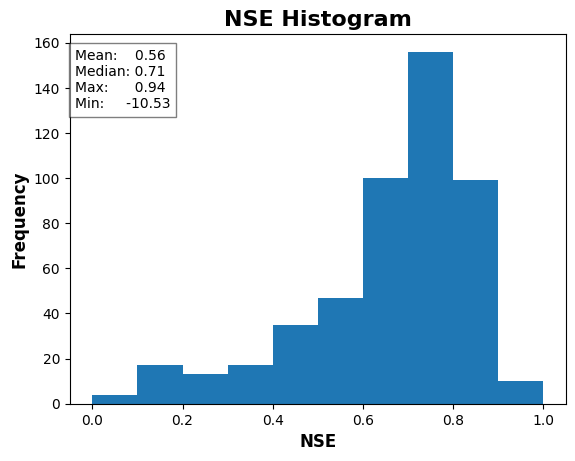

In [12]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Add NSE statistics to the plot
plt.text(
    0.01,
    0.8,
    (
        f'Mean: {"%.2f" % df_NSE["NSE"].mean():>7}\n'
        f'Median: {"%.2f" % df_NSE["NSE"].median():>0}\n'
        f'Max: {"%.2f" % df_NSE["NSE"].max():>9}\n'
        f'Min: {"%.2f" % df_NSE["NSE"].min():>10}'
    ),
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
# plt.savefig(save_folder+"/NSE_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

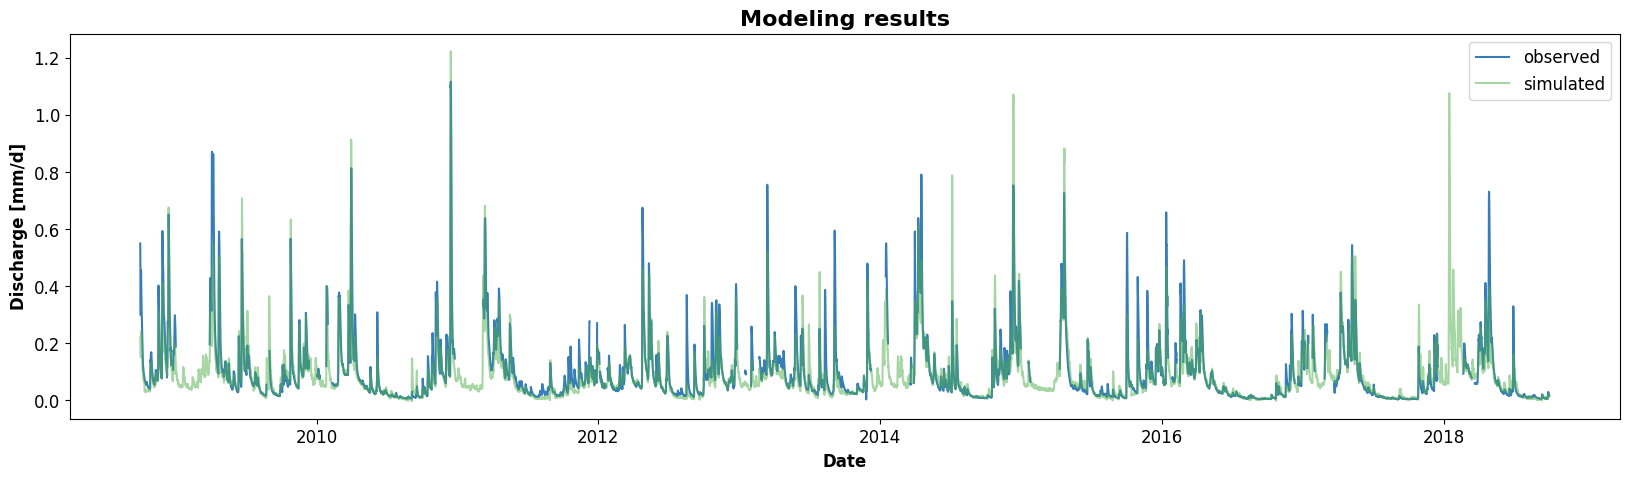

In [13]:
# Plot simulated and observed discharges
basin_to_analyze = "01022500"

plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Modeling results", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right", fontsize=12)